### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants
from human_eval_utils import parse_python_code, construct_test_program, code_runs_without_errors, save_results, get_erratic_problems, test_humaneval_parallel
from generic_agents.CodeInterpreterAgent import CodeInterpreterAgent
from utils import print_dict

### Loading the HumanEval Dataset

In [2]:
from human_eval_utils import load_human_eval

dataset = load_human_eval()

print(len(dataset))
task = dataset[-131]
# print a random example
print(task.keys())
print(task['prompt'])
print(task['entry_point'])
# print(task['test'])

164
dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'])


def sort_third(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the indicies that are not divisible by three, while its values at the indicies that are divisible by three are equal
    to the values of the corresponding indicies of l, but sorted.
    >>> sort_third([1, 2, 3])
    [1, 2, 3]
    >>> sort_third([5, 6, 3, 4, 8, 9, 2])
    [2, 6, 3, 4, 8, 9, 5]
    """

sort_third


### LangChain AgentCoder+

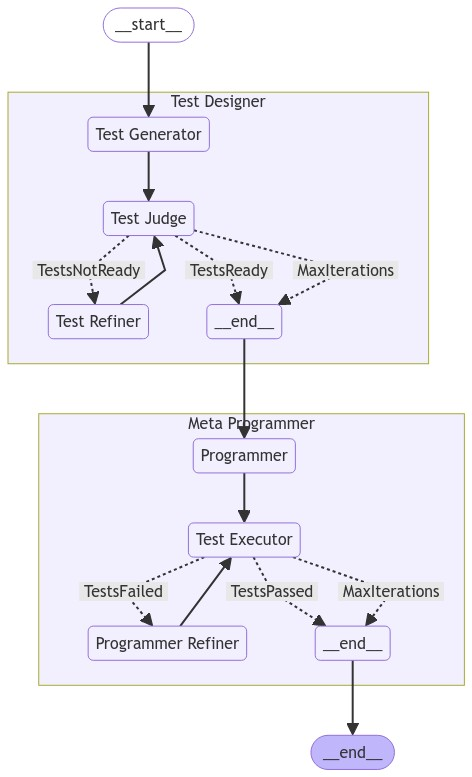

In [6]:
from langgraphs.agent_coder_plus import get_agent_coder_plus_graph
from IPython.display import Image, display

graph = get_agent_coder_plus_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 
png_data = app.get_graph(xray=True).draw_mermaid_png()
with open('/home/pedro/Downloads/6-AgentCoder_Plus_LangChain.png', 'wb') as f:
    f.write(png_data)

def agent_coder_plus(task_prompt, max_iterations=3, passed_tests_threshold=0.7):
    graph = get_agent_coder_plus_graph()
    app = graph.compile()
    
    config = {"recursion_limit": 50}
    inputs = {
        "incomplete_method": task_prompt,
        "max_iterations": max_iterations,
        "passed_tests_threshold": passed_tests_threshold,
    }

    for event in app.stream(inputs, config=config):
        pass
        # print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['completed_method']

#### HumanEval Evaluation

In [ ]:
# Usage
n_tasks = len(dataset)
task_numbers = range(0, n_tasks, 1)
# task_numbers = get_erratic_problems(file_path=constants.HUMAN_EVAL_SINGLE_AGENT_DIR)
# task_numbers = task_numbers[:n_tasks] if n_tasks is not None else task_numbers
passed_tests_threshold = 0.7
max_iterations = 6

results = test_humaneval_parallel(agent_coder_plus, task_numbers, dataset, max_iterations, passed_tests_threshold, 
                                  test_path=constants.HUMAN_EVAL_AGENT_CODER_PLUS_DIR, max_workers=8)
save_results(results, constants.HUMAN_EVAL_AGENT_CODER_PLUS_DIR) 

### LangChain MetaAgentCoder

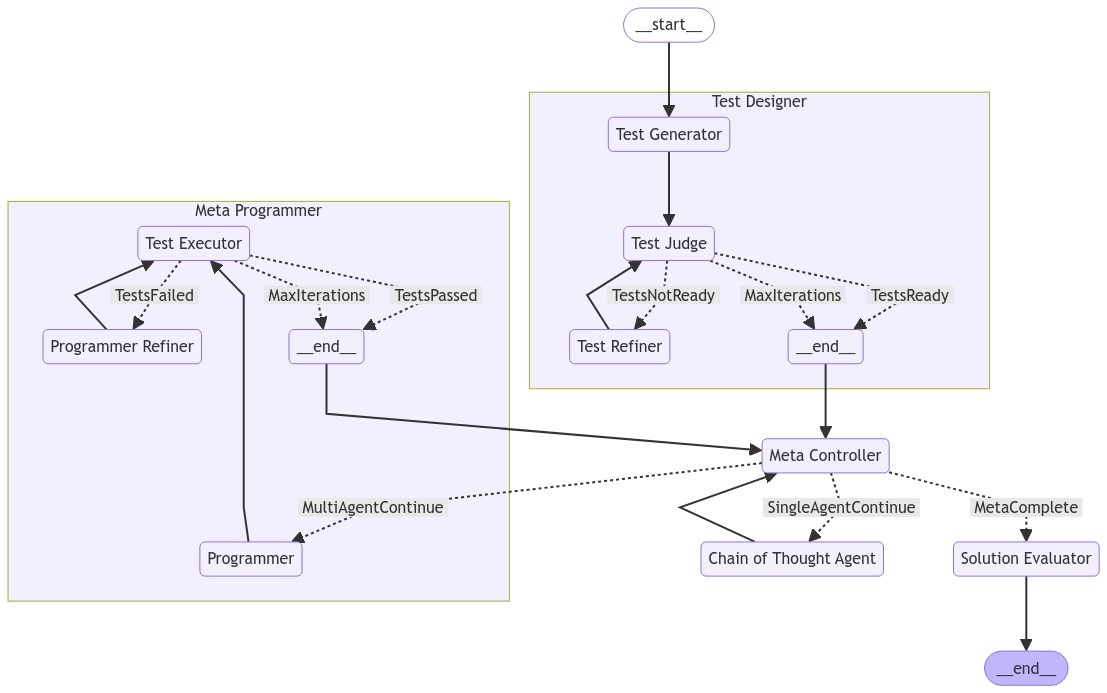

In [6]:
from langgraphs.meta_agent_coder import get_meta_agent_coder_graph
from IPython.display import Image, display

graph = get_meta_agent_coder_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 
png_data = app.get_graph(xray=True).draw_mermaid_png()
with open('/home/pedro/Downloads/9-MetaAgentCoderPlus_LangChain.png', 'wb') as f:
    f.write(png_data)

def meta_agent_coder(task_prompt, max_iterations=3, passed_tests_threshold=0.7):
    graph = get_meta_agent_coder_graph()
    app = graph.compile()
    
    config = {"recursion_limit": 50}
    inputs = {
        "incomplete_method": task_prompt,
        "max_iterations": max_iterations,
        "passed_tests_threshold": passed_tests_threshold,
        "current_iterations": 0,
        "current_meta_iterations": 0,
        "n_multi_agent_iterations": 3,
        "multi_agent_completed": False,
        "final_answers": {},
    }

    for event in app.stream(inputs, config=config):
        pass
        # print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['final_answer']

#### HumanEval Evaluation

In [ ]:
# Usage
n_tasks = len(dataset)
task_numbers = range(0, n_tasks, 2**0)
# task_numbers = get_erratic_problems(file_path=constants.HUMAN_EVAL_SINGLE_AGENT_DIR)
# task_numbers = task_numbers[:n_tasks] if n_tasks is not None else task_numbers
passed_tests_threshold = 0.7
max_iterations = 6

results = test_humaneval_parallel(meta_agent_coder, task_numbers, dataset, max_iterations, passed_tests_threshold, 
                                  test_path=constants.HUMAN_EVAL_META_AGENT_CODER_DIR, max_workers=16, n_attempts=5)
save_results(results, constants.HUMAN_EVAL_META_AGENT_CODER_DIR) 

### Plots

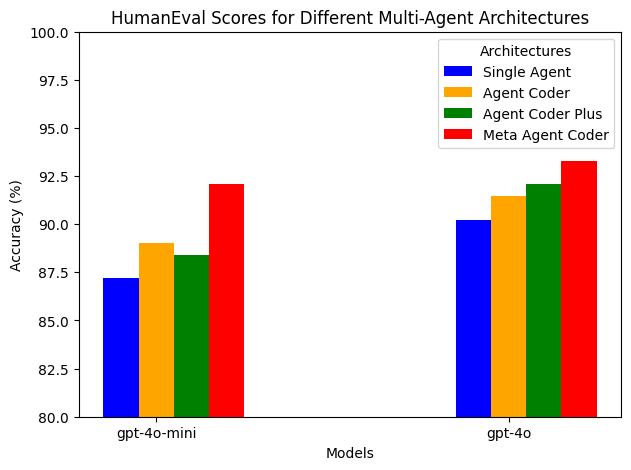

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_scores_from_jsons(base_directories, models, architectures, architecture_names, colors):
    """
    Plots a bar chart for the scores extracted from multiple JSON files for different models and architectures.
    
    Parameters:
    base_directories (list of str): A list of base directories corresponding to different models.
    models (list of str): A list of model names to be used as x-axis labels.
    architectures (list of str): A list of architecture names to be used in the legend.
    colors (list of str): A list of colors for each architecture.
    """
    scores = {arch: [] for arch in architectures}

    # Extract the score from each JSON file for each model and architecture
    for base_directory in base_directories:
        for arch, color in zip(architectures, colors):
            file_path = f"{base_directory}/{arch}/results.json"
            with open(file_path, 'r') as file:
                data = json.load(file)
                scores[arch].append(data['score'])

    # Create the bar plot
    x = np.arange(len(models))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot each architecture's scores
    for i, arch in enumerate(architectures):
        ax.bar(x + i*width, scores[arch], width, label=architecture_names[arch], color=colors[i])

    # Set the y-axis limits
    plt.ylim(80, 100)

    # Add labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('HumanEval Scores for Different Multi-Agent Architectures')
    ax.set_xticks(x + width)
    ax.set_xticklabels(models)

    # Add legend
    ax.legend(title="Architectures")

    # Show the plot
    plt.show()

# Example usage
base_directories = [
    constants.RESULTS_DIR + "human_eval/" + "gpt-4o-mini",
    constants.RESULTS_DIR + "human_eval/" + "gpt-4o",
]
models = ['gpt-4o-mini', 'gpt-4o']
architectures = ['single_agent', 'agent_coder', 'agent_coder_plus', 'meta_agent_coder']
architecture_names = {'single_agent': 'Single Agent', 'agent_coder': 'Agent Coder', 'agent_coder_plus': 'Agent Coder Plus', 'meta_agent_coder': 'Meta Agent Coder'}
colors = ['blue', 'orange', 'green', 'red']

plot_scores_from_jsons(base_directories, models, architectures, architecture_names, colors)
